# Table of Contents

1. [Strategy](#1-strategy)
   1. [Investment in the Housing Market](#11-investment-in-the-housing-market)
   2. [Investment in the Stock Market](#12-investment-in-the-stock-market)
   3. [Which is Better, Only Investing in the Stock Market or Dabbling in Both?](#13-which-is-better-only-investing-in-the-stock-market-or-dabbling-in-both)
      1. [Stock Market Investments Only](#stock-market-investments-only)
      2. [Stock Market and Housing Market Investments](#stock-market-and-housing-market-investments)
2. [Code Setup](#2-code-setup)
   1. [Load Crypto Stock Data](#21-load-crypto-stock-data)
   2. [Declare Default Values and Useful Functions](#22-declare-default-values-and-useful-functions)
   3. [Create the Training Model](#23-create-the-trading-model)
3. [Results and Analysis](#3-results-and-analysis)
   1. [When the Trades were Made Relative to the Stock Price's History](#31-when-the-trades-were-made-relative-to-the-stock-prices-history)
   2. [Convert the Portfolio History from Stock Units to USD](#32-convert-the-portfolio-history-from-stock-units-to-usd)
   3. [Value of the Asset in the Portfolio Over Time](#33-value-of-the-asset-in-the-portfolio-over-time)
   4. [Calculation of Overall Gains](#34-calculate-overall-gains)
4. [Possible Improvements](#4-possible-improvements)

# 1. Strategy

There are two possible investment opportunities that need to be evaluated before a successful strategy can be devised:

1. Housing Market Investments
2. Stock Market Investments

## 1.1 Investment in the Housing Market

An investment in the housing market requires a large sum of money upfront. This is due to the 5% downpayment requirement and upfront fees such as Notary fees ($1500), the realtor's commission (5% of sale price), and the Welcome tax ($5000). This high initial cost ($6500 minimum) alongside the fact that we only start with $1000 means that we won't be eligible to buy a house from the start. Therefore, We will need to use the other investment opportunity, the stock market, to make enough money to even consider buying a house.

Looking at the potential return from an investment in housing, we can see from figure 1 that the highest return we could make (assuming we buy immediately) is a mere 200%. This return in outmatched by some of the stock options due to their higher volatility which can be taken advantage of.

<div style="text-align: center;">
  <img src="plots/part1/HPI_over_time.png" width="400" />
  <figcaption>Figure 1. Lowest and Highest HPI Values over Time</figcaption>
</div>

However, there is a benefit to owning a house. Once purchased, a house grants $1000/month in savings. This annuity could be used to increase the total amount of capital we invest in either market. What's important to note is that simply adding more money in the market isn't guaranteed to result in a greater overall gain. There is an opportunity cost of when you invest that needs to be considered.

## 1.2 Investment in the Stock Market

Because we have access the historical price data of each stock, a unique opportunity presents itself. There's not need to speculate what the future price of any asset will be. This means that every investment will be a perfect trade. Due to every trade being perfect, stock with the most price volatility will results in the highest returns.

Therefore, the best investment strategy would be to buy and sell every dip and peak.

However, there is one consideration to make. Certain commodities have fees associated with their trades. This means that an otherwise highly profitable stock can turn sour if high enough fees are present. In order to guarantee a profitable trade, these fees will have to be taken into account.

Details about the trading algorithms present in the simulation are discussed in [section 2.3](#23-create-the-trading-model).

## 1.3 Which is Better, Only Investing in the Stock Market or Dabbling in Both?

### Stock Market Investments Only

If we only invest in the stock market, we can expect smaller individual returns that compound with themselves. Due to this compounding nature, our balance would experience exponential growth. This means that investing earlier is of the utmost importance. Making one or two more trades in the alloted period can result in a huge difference in our final balance.

### Stock Market and Housing Market Investments

Because we can only purchase a house after making a minimum of roughly $6500 (6.5 times our original amount), an opportunity cost will be incurred. Buying a house uses all of our existing capital, negating the gains we made with our stock market investments up to the point of purchase. This lowers the total amount of returns we can make in the stock market for the remaining period of time. The upside is that we get $1000/month to invest in the stock market and that we make around a 200% return on the price of the house. However, this flat, or in other words linear, annuity and low rate of return won't make up for the time lost due to buying a house.

In the end, investing only in the stock market seems like the better alternative due to it's compounding nature and the fact that buying a house incurs a large opportunity cost.


# 2. Code Setup

This section includes all the code necessary to run the portfolio simulation.


In [738]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

import pandas as pd
from termcolor import colored
from enum import Enum
import math

## 2.1 Load Crypto Stock Data

Load the historical price data from the `.csv` files located under `data/stock/` using pandas, keep only the date and closing price column, and store them in a dictionary for later use.

All historical price data was taken from [Yahoo Finance](https://finance.yahoo.com/) and [nasdaq.com](https://www.nasdaq.com/).

The data from [nasdaq.com](https://www.nasdaq.com/) had to be cleaned up to match the format of the Yahoo data.


In [739]:
stock_dataframes = {}

# Load the stock data from nasdaq.com
NASDAQ_STOCK_PATH = "data/stock/nasdaq/"
nasdaqStockFiles = [
  "NaturalGas.csv",
  "CrudeOil.csv",
  "NASDAQ.csv",
  "S&P500.csv",
  # "Gold.csv",   # Not including the metals
  # "Silver.csv",
  # "Copper.csv",
]

for file in nasdaqStockFiles:
  file_path = NASDAQ_STOCK_PATH + file
  df = pd.read_csv(file_path)

  # Keep only the Date and Close columns
  df = df[["Date", "Close"]]

  # Change the format of the dates to y-m-d
  df["Date"] = pd.to_datetime(df["Date"])

  # Keep only the data from 2015-07-01 to 2024-07-31 per month
  date_mask = (df["Date"] >= "2015-07-01") & (df["Date"] <= "2024-07-31")
  df = df.loc[date_mask]

  # Reverse the order of the Date column
  df = df[::-1]
  df.reset_index(drop=True, inplace=True)

  df_copy = df.copy()

  df_copy = df_copy[df_copy["Date"].dt.day == 1]
  df_copy.reset_index(drop=True, inplace=True)

  # Find the missing months
  all_months = pd.date_range(start="2015-07-01", end="2024-07-01", freq="MS")
  missing_months = all_months.difference(df_copy["Date"])

  # Iterate over the missing months
  for missing_month in missing_months:
    # Find the closest day to the 1st of the month
    closest_day = (
      df.loc[df["Date"].dt.month == missing_month.month, "Date"]
      .apply(lambda x: abs((x - missing_month).days))
      .idxmin()
    )

    # Get the value for the closest day
    closest_value = df.loc[closest_day, "Close"]

    # Add the missing month with the closest value
    new_row = pd.DataFrame({"Date": [missing_month], "Close": [closest_value]})
    df_copy = pd.concat([df_copy, new_row], ignore_index=True)

  # Sort the dataframe by date
  df_copy = df_copy.sort_values("Date").reset_index(drop=True)

  # Store the DataFrame in the dictionary
  stock_dataframes[file.split(".")[0]] = df_copy

# Load the stock data from Yahoo Finance
YAHOO_STOCK_PATH = "data/stock/yahoo/"
yahooStockFiles = [
  "EUR.csv",
  "JPY.csv",
  "GBP.csv",
  "AUD.csv",
  "CAD.csv",
]

for file in yahooStockFiles:
  file_path = YAHOO_STOCK_PATH + file
  df = pd.read_csv(file_path)

  # Keep only the Date and Close columns
  df = df[["Date", "Close"]]

  # Store the DataFrame in the dictionary
  stock_dataframes[file.split(".")[0]] = df

## 2.2 Declare Default Values and Useful Functions

The simulation start on 2015-07-01 and ends on 2024-07-31.

For simplification, we only work in USD. Therefore, the initial balance was converted from CAD to USD on day 1.

There are also 3 helper functions `buy()`, `sell()`, and `handleFees()`. Importantly, `handleFees()` factors in the different kinds of fees associated with each type of transaction for each type of asset.

These fees are summarized in the table below:

| Type                  | Fee / Trade | Extra      |
| --------------------- | ----------- | ---------- |
| **Stock Market**      | 9.95$       |            |
| **Gold**              | 28.95$      | $1 / oz.   |
| **Other Metals**      | 28.95$      | $0.1 / oz. |
| **Other Commodities** | 9.95$       |            |
| **Currencies**        | 1.6%        |            |


In [740]:
START_DATE = "2015-07-01"
END_DATE = "2024-07-31"

USD_TO_CAD_JULY_2015 = 1.261

# 1000 CAD converted to USD on July 2015
STARTING_BALANCE = 1000 / USD_TO_CAD_JULY_2015


def startingPortfolio(stockName):
  # Create a new DataFrame to log portfolio values
  portfolio_df = pd.DataFrame(columns=["Date", "Cash", stockName])

  # Set the initial portfolio values
  portfolio_df.loc[0] = {
    "Date": START_DATE,
    "Cash": STARTING_BALANCE,
    stockName: 0,
  }

  return portfolio_df


TRADE_FEES = {
  "stockMarket": 9.95,
  "currencies": 1.6 / 100,
  "gold": [28.95, {"perOunce": 1}],
  "metals": [28.95, {"perOunce": 0.1}],
}

STOCK_TYPES = {
  "EUR": "currencies",
  "JPY": "currencies",
  "GBP": "currencies",
  "AUD": "currencies",
  "CAD": "currencies",
  "CrudeOil": "stockMarket",
  "NaturalGas": "stockMarket",
  "NASDAQ": "stockMarket",
  "S&P500": "stockMarket",
  "Gold": "gold",
  "Silver": "metals",
  "Copper": "metals",
}


def handleFees(commodity, money, tradeType, units=0) -> float:
  match STOCK_TYPES[commodity]:
    case "stockMarket":
      money -= TRADE_FEES["stockMarket"]
    case "currencies":
      money -= money * TRADE_FEES["currencies"]
    case "gold":
      if tradeType == "Buy":
        money -= units * TRADE_FEES["gold"][1]["perOunce"]
      elif tradeType == "Sell":
        money -= units * TRADE_FEES["gold"][1]["perOunce"]

      money -= TRADE_FEES["gold"][0]
    case "metals":
      if tradeType == "Buy":
        money -= units * TRADE_FEES["metals"][1]["perOunce"]
      elif tradeType == "Sell":
        money -= units * TRADE_FEES["metals"][1]["perOunce"]

      money -= TRADE_FEES["metals"][0]
    case _:
      print(f"{commodity} does not have a valid STOCK_TYPE")

  return money


def sellMax(portfolio, commodity, date, debug=False) -> float:
  availableUnits = portfolio.tail(1)[commodity].values[0]

  commodity_df = stock_dataframes[commodity]
  currentPrice = commodity_df.loc[commodity_df["Date"] == date, "Close"].values[0]

  profit = availableUnits * currentPrice

  if debug:
    print(
      f"{date}: {colored("Selling", "red")} {availableUnits} {commodity} at ${currentPrice:.2f}/{commodity} for a profit of ${profit:.2f}\n"
    )

  profit = handleFees(commodity, profit, availableUnits, "Sell")

  return profit


def buyMax(portfolio, commodity, date, debug=False) -> float:
  availableCash = portfolio.tail(1)["Cash"].values[0]

  commodity_df = stock_dataframes[commodity]
  commodityPrice = commodity_df.loc[commodity_df["Date"] == date, "Close"].values[0]

  availableCash = handleFees(
    commodity, availableCash, availableCash / commodityPrice, "Buy"
  )

  if debug:
    print(
      f"{date}: {colored("Buying", "green")} ${availableCash:.2f} ({availableCash / commodityPrice} {commodity}) worth of {commodity} at ${commodityPrice:.2f}/{commodity}\n"
    )

  return availableCash / commodityPrice

Some constant declarations for the simulation and plots.


In [741]:
STOCK_COLORS = {
  "Cash": "blue",
  "EUR": "green",
  "AUD": "orange",
  "CAD": "red",
  "GBP": "purple",
  "JPY": "skyblue",
  "CrudeOil": "black",
  "NaturalGas": "pink",
  "NASDAQ": "grey",
  "S&P500": "cyan",
  "Gold": "gold",
  "Silver": "silver",
  "Copper": "brown",
}

# Buy Trade Marker
GREEN_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="green",
  marker="^",
  linestyle="None",
  markersize=7,
  label="Buy Trade",
)
# Sell Trade Marker
RED_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="red",
  marker="v",
  linestyle="None",
  markersize=7,
  label="Sell Trade",
)


class Trend(Enum):
  NONE = 0
  INCREASE = 1
  DECREASE = 2

## 2.3 Create the Trading Model

The simulation iterates through every month for each stock. The stock is bought whenever the simulation is at a local minima and sold when at a local maxima. The following algorithm is used to detect minima and maximas:

```bash
previousTrend = None
for month in period:
  currentPrice = price(month)
  nextMonth = month + 1_month
  nextPrice = price(nextMonth)

  if nextPrice > currentPrice:
      if previousTrend == DECREASE:
        buyMax()
      previousTrend = INCREASE
  else if nextPrice < currentPrice:
    if previousTrend == INCREASE:
      sellMax()

    previousTrend = DECREASE
```

This simple algorithm works well for stocks that have low fees (flat fees).

However, it wasn't suitable for stock with fees that scale with the buy and sell price of the trade. This would results in trades being made that lost money (figure 2).

<div style="text-align: center;">
  <img src="plots/part1/CAD-Values (All Dips Bought).png" height="350" />
  <figcaption>Figure 2. Value of CAD in Portfolio Over Time Using Naive Algorithm Only</figcaption>
</div>

Therefore, new algorithm to determine if a trade was profitable was needed.

To determine the profitability of the trade, we need to know the buy price and the sell price to calculate the return rate. After subtracting the effect fees have on the rate of return, we can determine if the trade is profitable and if it should or shouldn't be made.

Since there are different fees for each commodity, different calculations are needed for each case. The algorithm for a general case is as follows:

```bash
    lowestPrice = currentPrice # The current price is the lowest because of the previous algorithm
    highestPrice = findNextHighestPrice()

    profitMultiplier = highestPrice / lowestPrice

    if (profitMultiplier - tradeFeeRate) > 1:
      buy()
    else:
      sell()
```

At the end of the simulation, we keep track of the portfolio and trade histories as well as the final balances of all portfolios.


In [742]:
def findNextHighestPrice(stock, date, currentPrice, nextPrice):
  nextDate = date

  while nextPrice > currentPrice:
    currentPrice = nextPrice
    nextDate = (pd.Timestamp(nextDate) + pd.DateOffset(months=1)).strftime("%Y-%m-%d")
    nextPrice = stock.loc[stock["Date"] == nextDate, "Close"]
    if nextPrice.empty:
      break
    nextPrice = nextPrice.values[0]

  return currentPrice


def simulate(portfolio, stock, stockName, debug=False):
  trades = []
  stockType = STOCK_TYPES[stockName]
  previousTrend = Trend.NONE
  for date in stock["Date"]:
    nextDate = (pd.Timestamp(date) + pd.DateOffset(months=1)).strftime("%Y-%m-%d")
    currentPrice = stock.loc[stock["Date"] == date, "Close"].values[0]
    nextPrice = stock.loc[stock["Date"] == nextDate, "Close"]
    if nextPrice.empty:
      continue
    nextPrice = nextPrice.values[0]

    lastRow = portfolio.tail(1)
    newRow = lastRow.copy()
    newRow["Date"] = date

    if nextPrice > currentPrice:
      if previousTrend == Trend.DECREASE:
        match stockType:
          case "currencies":
            highestPrice = findNextHighestPrice(stock, date, currentPrice, nextPrice)
            # The current price is the lowest price
            profitMultiplier = highestPrice / currentPrice
            # Trade fees apply on buy and sell. So multiply by 2
            if profitMultiplier - (TRADE_FEES["currencies"] * 2) < 1:
              # Don't buy, not profitable
              portfolio = pd.concat([portfolio, newRow], ignore_index=True)
              continue
          case "gold":
            pass
            # highestPrice = findNextHighestPrice(stock, date, currentPrice, nextPrice)
            # profitMultiplier = highestPrice / currentPrice
            # flatFeeMulti = (
            #   1 - (currentPrice - TRADE_FEES["gold"][0]) / currentPrice
            # ) + (1 - (highestPrice - TRADE_FEES["gold"][0]) / highestPrice)
            # perOunceFeeMulti = (
            #   1 - ((currentPrice - TRADE_FEES["gold"][1]["perOunce"]) / currentPrice)
            # ) + (
            #   1 - ((highestPrice - TRADE_FEES["gold"][1]["perOunce"]) / highestPrice)
            # )
            # print(
            #   f"profitMultiplier: {profitMultiplier}, flatFeeMulti: {flatFeeMulti}, perOunceFeeMulti: {perOunceFeeMulti}"
            # )
            # if profitMultiplier - (flatFeeMulti + perOunceFeeMulti) < 1:
            #   # Don't buy, not profitable
            #   portfolio = pd.concat([portfolio, newRow], ignore_index=True)
            #   continue
          case "metals":
            pass
          case _:
            # Always profitable
            pass
        units = buyMax(portfolio, stockName, date, debug=debug)

        newRow["Cash"] = 0
        newRow[stockName] = lastRow[stockName] + units
        trades.append(
          {
            "Date": date,
            "Stock": stockName,
            "Type": "Buy",
            "Amount": float(units),
          }
        )

      previousTrend = Trend.INCREASE
    elif nextPrice < currentPrice:
      if previousTrend == Trend.INCREASE:
        sellCash = sellMax(portfolio, stockName, date, debug=debug)

        newRow["Cash"] = lastRow["Cash"] + sellCash
        newRow[stockName] = 0

        trades.append(
          {
            "Date": date,
            "Stock": stockName,
            "Type": "Sell",
            "Amount": float(sellCash),
          }
        )

      previousTrend = Trend.DECREASE

    portfolio = pd.concat([portfolio, newRow], ignore_index=True)

  # On the last day, sell all the stocks
  lastRow = portfolio.tail(1)
  newRow = lastRow.copy()

  if lastRow[stockName].values[0] != 0:
    sellCash = sellMax(portfolio, stockName, date, debug=debug)
    newRow["Cash"] = lastRow["Cash"] + sellCash
    newRow[stockName] = 0
    trades.append(
      {
        "Date": date,
        "Stock": stockName,
        "Type": "Sell",
        "Amount": float(sellCash),
      }
    )
    portfolio = pd.concat([portfolio, newRow], ignore_index=True)

  return (portfolio, trades)


tradeHistories = {}
portfolioHistories = {}
finalBalances = {}
for stockName, stock_df in stock_dataframes.items():
  portfolio_df = startingPortfolio(stockName)
  history, trades = simulate(portfolio_df, stock_df, stockName)
  portfolioHistories[stockName] = history
  tradeHistories[stockName] = trades
  finalBalances[stockName] = history.tail(1)["Cash"].values[0]

# 3. Results and Analysis

> **Note:** The metals aren't included in the analysis due to their exorbitant fees (and some issues with the simulation).

## 3.1 When the Trades were Made Relative to the Stock Price's History

Since none of the trades were hard coded, the following graphs illustrate when the trades were made relative to the stock price history of each commodity.

There is a clear pattern of buying low and selling high at each opportunity (if profitable).

Notably, the currencies have less trades overall. This is due to the percent fee applied on each trade which cuts into their overall return rate.


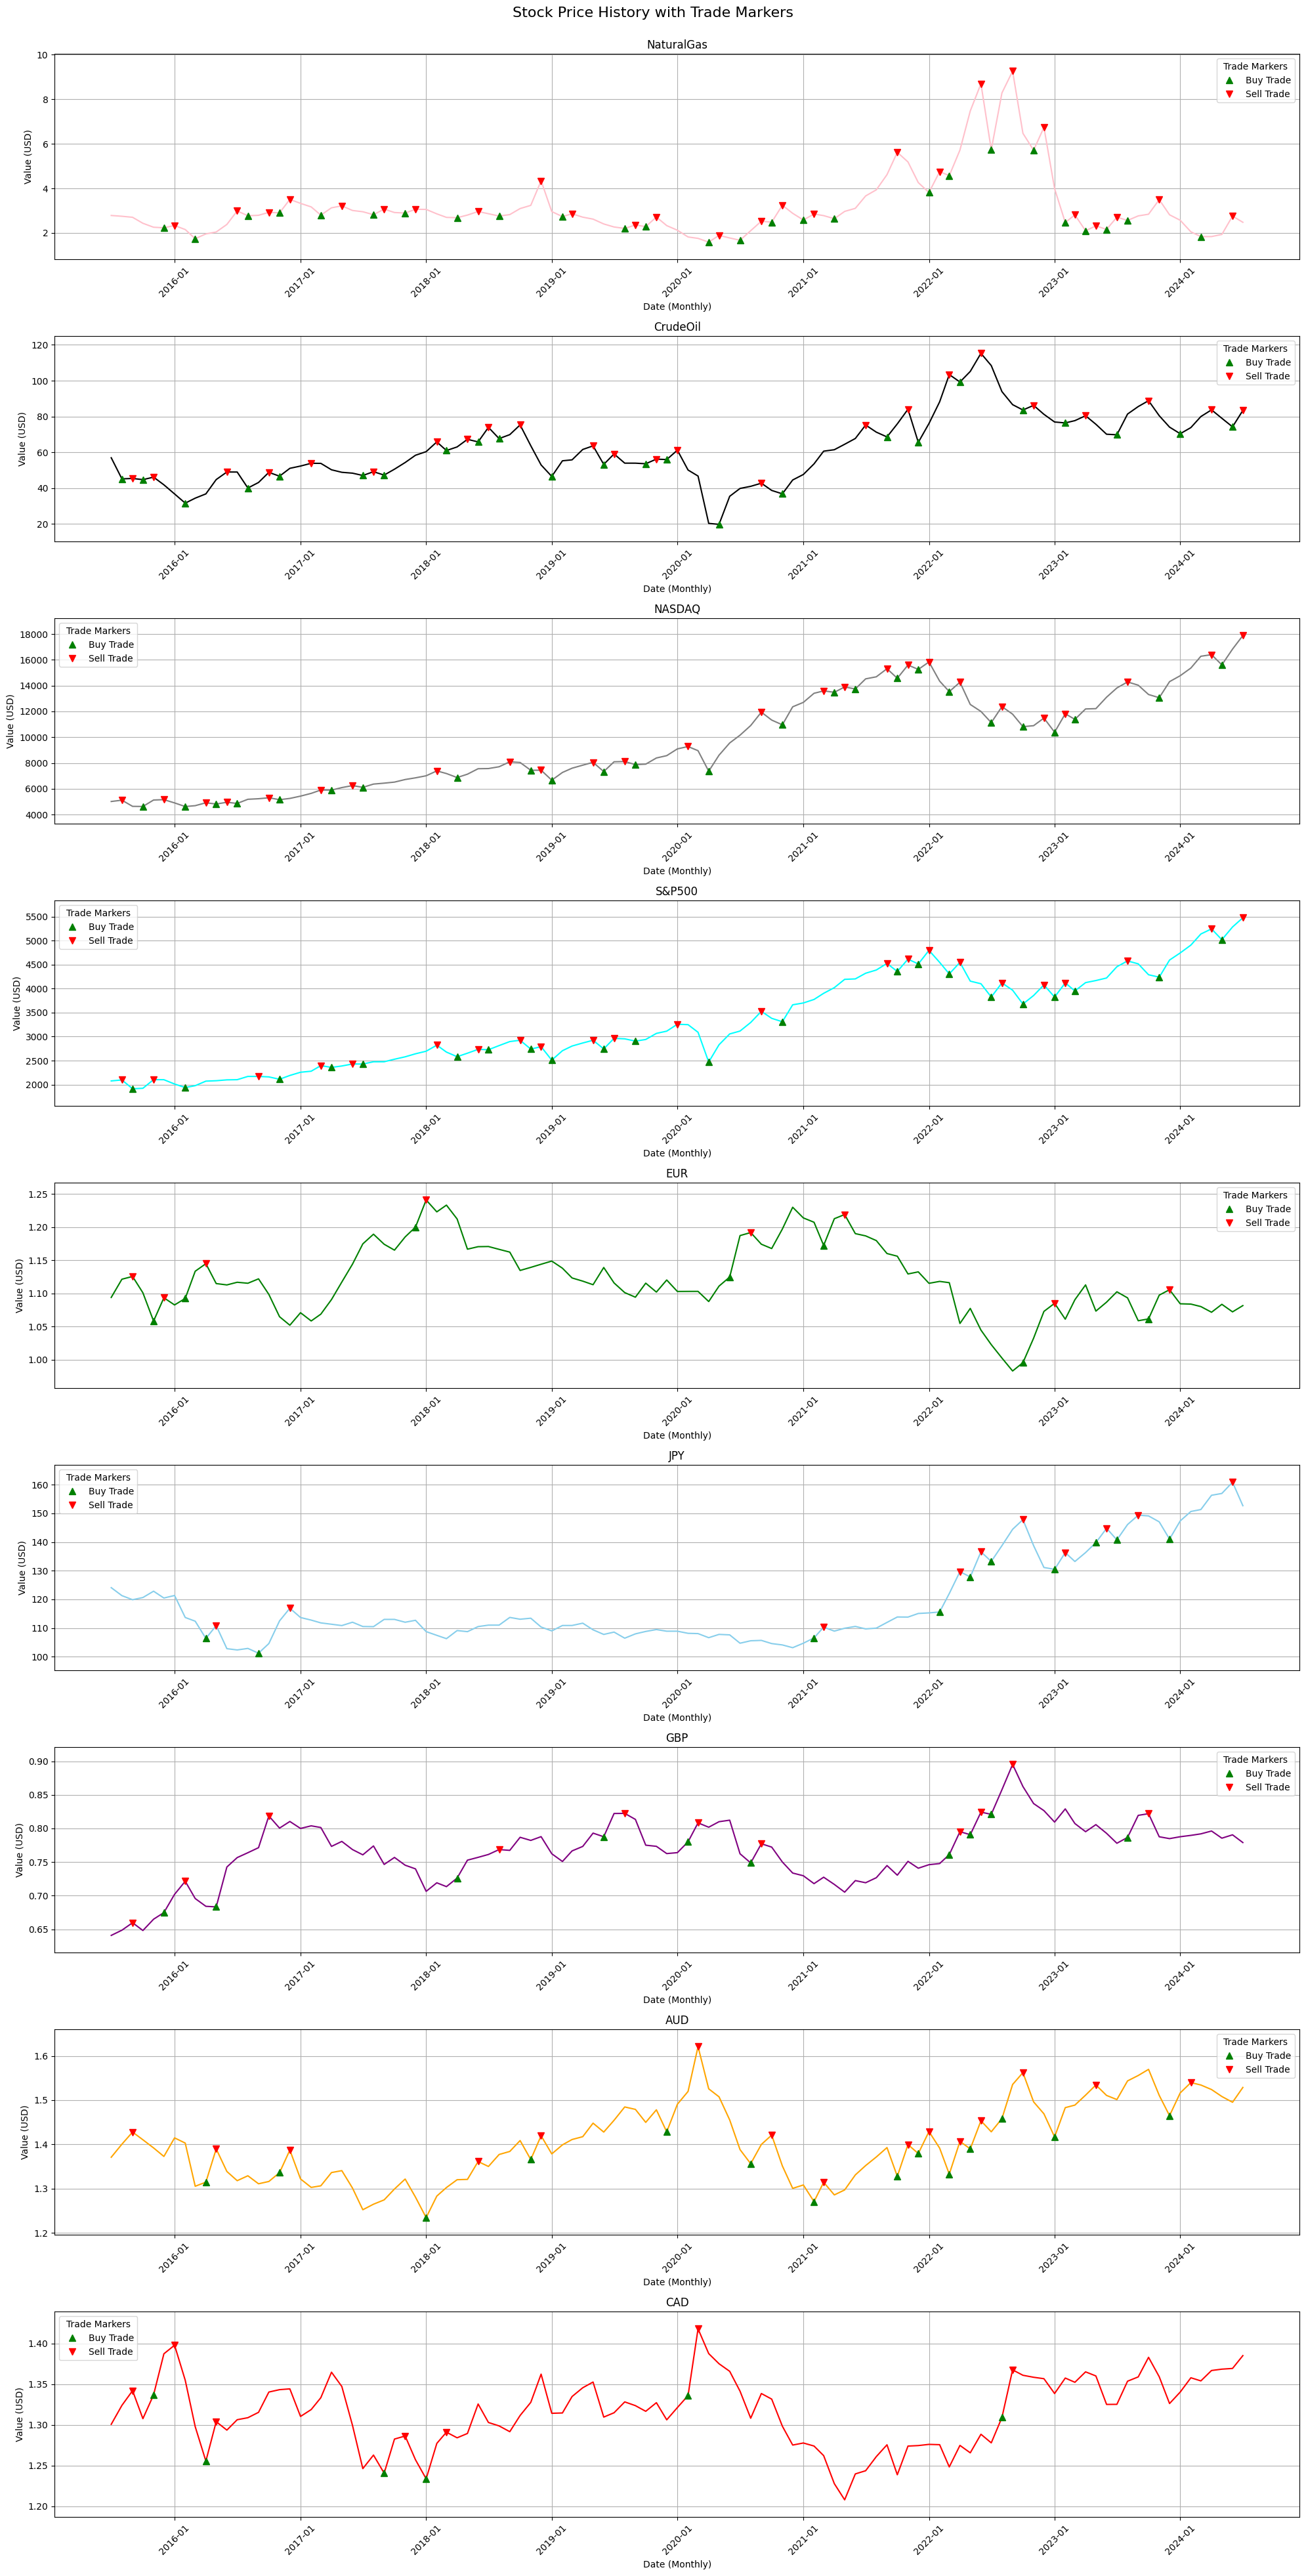

In [743]:
# Create a grid of subplots
fig, axs = plt.subplots(len(stock_dataframes), 1, figsize=(20, 40))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

stock_dataframes_copy = stock_dataframes.copy()

for i, (stock, df) in enumerate(stock_dataframes_copy.items()):
  df = df.copy()
  df["Date"] = pd.to_datetime(df["Date"])

  axs[i].plot(
    df["Date"],
    df["Close"],
    color=STOCK_COLORS[stock],
  )
  axs[i].set_title(f"{stock}")
  axs[i].set_xlabel("Date (Monthly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Adjust y-axis limits to make small changes more visible
  min_close = df["Close"].min()
  max_close = df["Close"].max()
  padding = (max_close - min_close) * 0.1  # Add 10% padding
  axs[i].set_ylim(min_close - padding, max_close + padding)

  # Add markers for trades
  for trade in tradeHistories[stock]:
    tradeType = trade["Type"]
    tradeCommodity = trade["Stock"]
    tradeDate = pd.to_datetime(trade["Date"])

    if stock != tradeCommodity:
      continue

    if tradeType == "Buy":
      marker = "^"
      color = "green"
    elif tradeType == "Sell":
      marker = "v"
      color = "red"

    # Get y value for the marker
    y_value = df.loc[df["Date"] == tradeDate, "Close"].values[0]
    # Plot the marker
    axs[i].plot(tradeDate, y_value, marker=marker, color=color, markersize=7)

  # Add the marker legend
  axs[i].legend(handles=[GREEN_TRIANGLE, RED_TRIANGLE], title="Trade Markers")

fig.suptitle(
  "Stock Price History with Trade Markers",
  fontsize=16,
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 3.2 Convert the Portfolio History From Stock Units to USD

This section converts the stock amounts in the portfolio history from units (e.g. 11 oz gold) to USD.

This conversion is helpful when visualizing the data because people have a better frame of reference for USD rather than units of stock.


In [744]:
convertedPortfolioHistories = {}
for stockName, portfolio in portfolioHistories.items():
  convertedPortfolioHistory = portfolio.copy()
  # Convert the portfolio history from crypto units to USD
  for date in convertedPortfolioHistory["Date"]:
    stock_df = stock_dataframes[stockName]
    if date in stock_df["Date"].values:
      stockUnits = portfolio.loc[portfolio["Date"] == date, stockName].values[0]
      if stockUnits > 0:
        stockPrice = stock_df.loc[stock_df["Date"] == date, "Close"].values[0]

        convertedPortfolioHistory.loc[
          convertedPortfolioHistory["Date"] == date, stockName
        ] = stockUnits * stockPrice
  convertedPortfolioHistories[stockName] = convertedPortfolioHistory

## 3.3 Value of the Asset in the Portfolio Over Time

The following plots show the values of the cash and traded asset in each portfolio over time. Additionally, you can find the final balance amount and overall percent gain for each commodity annotated on each plot.


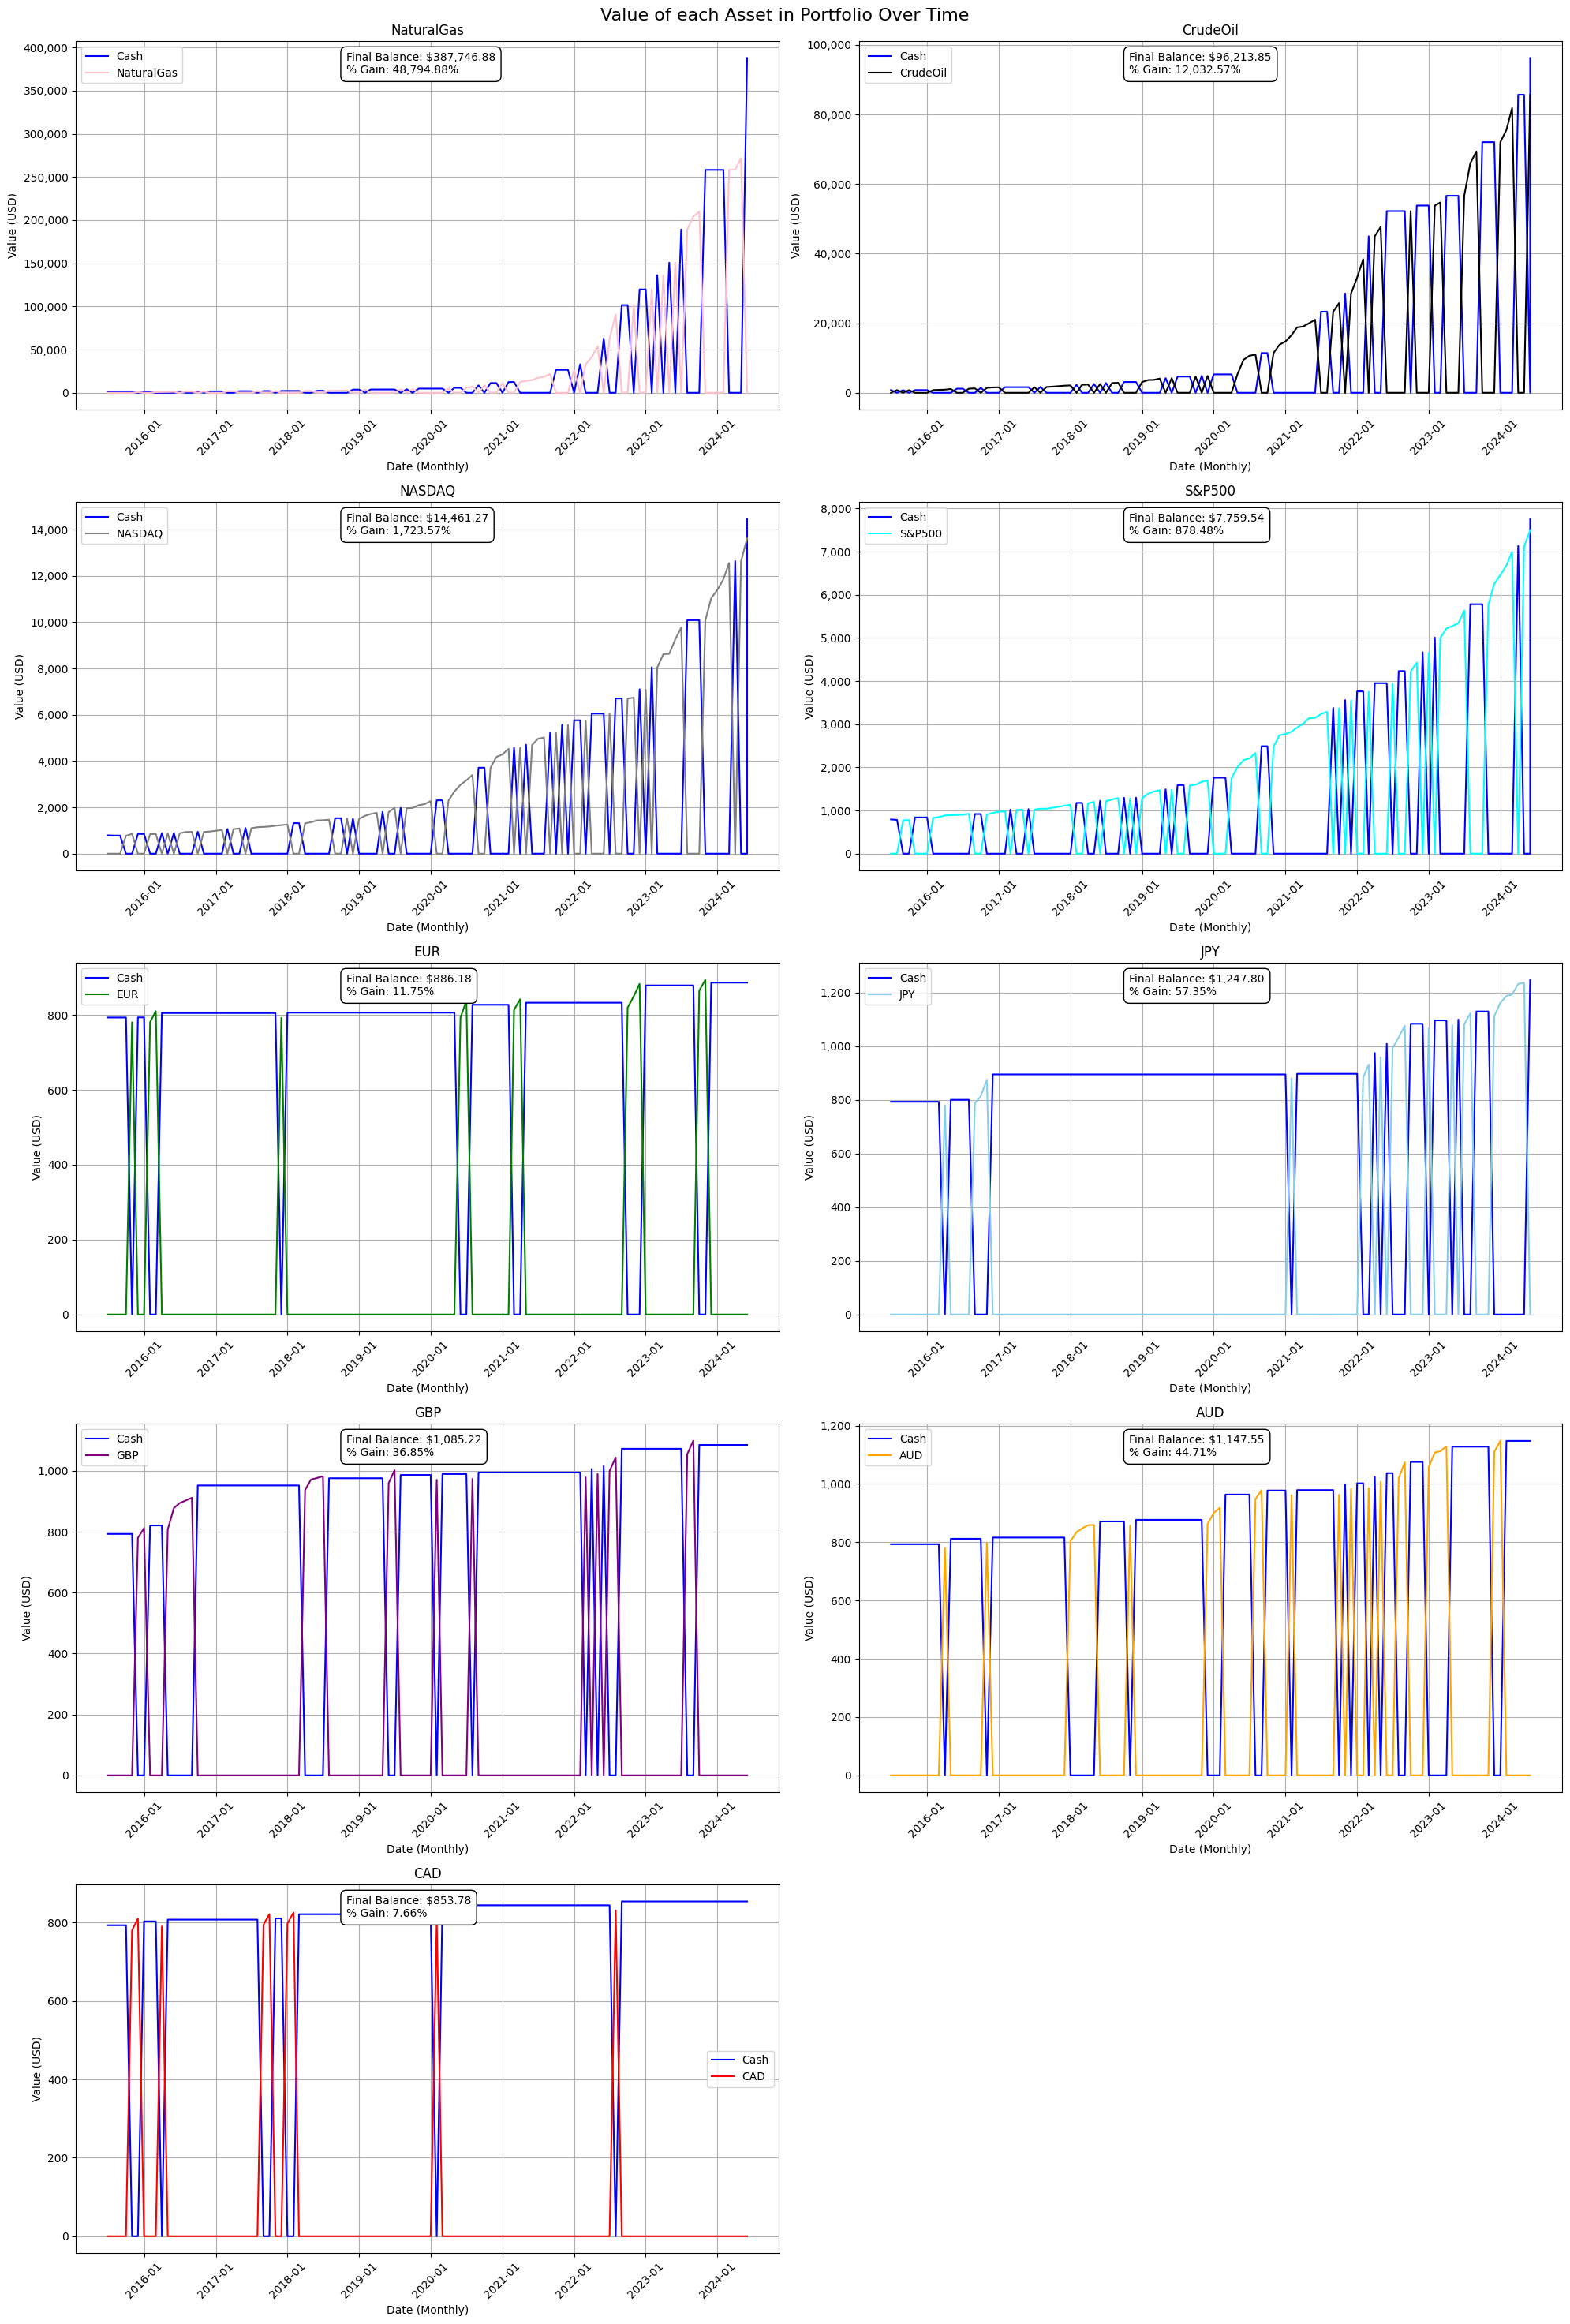

In [745]:
# Ensure the Date column is in datetime format
for stockName, portfolio in convertedPortfolioHistories.items():
  portfolio["Date"] = pd.to_datetime(portfolio["Date"])

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(math.ceil(len(stock_dataframes) / 2), 2, figsize=(20, 30))

# Flatten the 2x3 array of axes for easy iteration
axs = axs.flatten()

# Plot each column in a separate subplot with a different color
for i, (stockName, portfolio) in enumerate(convertedPortfolioHistories.items()):
  axs[i].plot(
    portfolio["Date"],
    portfolio["Cash"],
    color=STOCK_COLORS["Cash"],
    label="Cash",
  )
  axs[i].plot(
    portfolio["Date"],
    portfolio[stockName],
    color=STOCK_COLORS[stockName],
    label=stockName,
  )

  # Add annotation for the final balance
  axs[i].annotate(
    f"Final Balance: ${finalBalances[stockName]:,.2f}\n% Gain: {(finalBalances[stockName] - STARTING_BALANCE) / STARTING_BALANCE * 100:,.2f}%",
    xy=(0.4, 1),
    xycoords="axes fraction",
    xytext=(-10, -10),
    textcoords="offset points",
    ha="left",
    va="top",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
  )

  axs[i].set_title(stockName)
  axs[i].set_xlabel("Date (Monthly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Use ScalarFormatter to avoid scientific notation
  formatter = ScalarFormatter(useOffset=False)
  formatter.set_scientific(False)
  axs[i].yaxis.set_major_formatter(formatter)
  # Add commas to y-axis values
  axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

  # Add legend
  axs[i].legend()

# Remove any unused axes
for j in range(i + 1, len(axs)):
  fig.delaxes(axs[j])

# Add a title to the figure
fig.suptitle("Value of each Asset in Portfolio Over Time", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

It's clear that each trade was profitable as the cash line only increases over time.


## 3.4 Calculation of Overall Gains

Below is a calculation of the overall gains for each commodity using the results of the aforementioned simulation.

We use the following equation to calculate the gains:
$$Percent \space Gain = \frac{(Final \space Amount - Initial \space Amount)}{Initial \space Amount}*100$$

All final amounts are relative to 2015-07-01 and have had their inflation accounted for.


In [746]:
# Ignore this color hack =)

COLOR_MAPPING = {
  "purple": "magenta",
  "orange": "yellow",
  "skyblue": "cyan",
  "pink": "light_red",
  "gold": "yellow",
  "silver": "light_grey",
  "grey": "dark_grey",
}


# Function to get a supported color for colored
def get_supported_color(color):
  return COLOR_MAPPING.get(color, color)

In [747]:
def percentGain(final, start):
  return ((final - start) / start) * 100


# Account for Inflation
TOTAL_CPI_2015_07 = 127.3  # Consumer Price Index for July 2015
TOTAL_CPI_2024_06 = (
  161.4  # Consumer Price Index for June 2024 (Didn't have July 2024 data)
)

INFLATION_FACTOR = TOTAL_CPI_2015_07 / TOTAL_CPI_2024_06  # Relative to July 2015

for stockName, finalBalance in finalBalances.items():
  finalBalancePostInflation = finalBalance * INFLATION_FACTOR
  print(
    colored(
      f"Simulating {stockName}:",
      get_supported_color(STOCK_COLORS[stockName])
      if STOCK_COLORS[stockName]
      in ["purple", "orange", "skyblue", "pink", "gold", "silver", "grey"]
      else STOCK_COLORS[stockName],
    )
  )
  print(f"Starting Balance: ${STARTING_BALANCE:,.2f}")
  print(f"Final Balance: ${finalBalance:,.2f}")
  print(
    f"Final Balance post-inflation (Relative to July 2015): ${finalBalancePostInflation:,.2f}\n"
  )
  print(
    f"Percent Gain (Relative to July 2015): {percentGain(finalBalancePostInflation, STARTING_BALANCE):,.2f}%\n"
  )

Simulating NaturalGas:
Starting Balance: $793.02
Final Balance: $387,746.88
Final Balance post-inflation (Relative to July 2015): $305,825.14

Percent Gain (Relative to July 2015): 38,464.55%

Simulating CrudeOil:
Starting Balance: $793.02
Final Balance: $96,213.85
Final Balance post-inflation (Relative to July 2015): $75,886.14

Percent Gain (Relative to July 2015): 9,469.24%

Simulating NASDAQ:
Starting Balance: $793.02
Final Balance: $14,461.27
Final Balance post-inflation (Relative to July 2015): $11,405.95

Percent Gain (Relative to July 2015): 1,338.29%

Simulating S&P500:
Starting Balance: $793.02
Final Balance: $7,759.54
Final Balance post-inflation (Relative to July 2015): $6,120.13

Percent Gain (Relative to July 2015): 671.75%

Simulating EUR:
Starting Balance: $793.02
Final Balance: $886.18
Final Balance post-inflation (Relative to July 2015): $698.95

Percent Gain (Relative to July 2015): -11.86%

Simulating JPY:
Starting Balance: $793.02
Final Balance: $1,247.80
Final Bal

After calculating the results, investing the initial $1000 CAD into the Natural Gas stock resulted in the largest overall gain of 38,464.55% leaving a final balance (post inflation) of $305,825.14.


# 4. Possible Improvements

One of the most obvious improvements that could be made to the trading simulation is to take the data gained from running the first simulation on each stock and use it to optimize the trades that were made.

One possibility would be to group each pair of buy-sell trades and sort them by their rate of return. With the sorted list of trade pairs, the ones with the highest returns could be selected and used in a future simulation. However, you would have to make sure none of the trades conflict with each other timing wise. To resolve this issue, you would prioritize the trades with higher rates of return so long as there weren't multiple smaller trades that could be made in the same time frame that would cumulatively result in a greater overall return.
